This code allows balls tracking in fly pushing experiments.

For now, proved successful in single corridor arenas with 1 fly and 1 ball, with different arena materials.

# Libraries

In [2]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt

# Path definition

In [38]:
VideoPath = Path(
    '/mnt/labserver/DURRIEU_Matthias/Experimental_data/Optogenetics/Optobot/MultiMazeBiS_Steel15_Wax/Starved_noWater_MagnetBlock/221130/093728_s0a0_p0-0/Arena6/Arena6.mp4')

In [3]:
#Mac path
VideoPath = Path(
    '/Volumes/Ramdya-Lab/DURRIEU_Matthias/Experimental_data/Optogenetics/Optobot/MultiMazeBiS_15_Steel_Wax/Female_Starved_noWater/221116/102044_s0a0_p6-0/Arena4/Arena4.mp4'
)

## Quickly check first frame

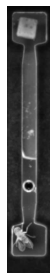

In [4]:
%matplotlib inline

vidcap = cv2.VideoCapture(VideoPath.as_posix())
for i in range(1):
    success, im_full = vidcap.read()

im_full_gray = cv2.cvtColor(im_full, cv2.COLOR_BGR2GRAY)

#hv.Image(im_full_gray)

plt.figure()
plt.axis('off')
plt.tight_layout()
plt.imshow(im_full_gray, cmap='gray', vmin=0, vmax=255); # semicolon removes print of matplotlib object

# Optional : Fine tune tracking parameters for new videos

## Generate trimmed version of the video

In [5]:
#Choose the start and finish timestamps
startpoint = "00:00:00"

finishpoint = "00:02:00"
TrimmedPath = VideoPath.with_stem(VideoPath.stem + "_Trimmed")

os.system(  # Ffmpeg +
        "ffmpeg -hide_banner -loglevel error -i "
        + VideoPath.as_posix()
        + " -ss "
        + startpoint
        + " -to "
        + finishpoint
        + " -c copy "
        + TrimmedPath.as_posix()
    )

0

## Play with y cropping parameters to center ROI on corridor without chambers

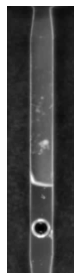

In [6]:
%matplotlib inline

cropping_parameters = (120,650)
cropped = im_full_gray[cropping_parameters[0]:cropping_parameters[1],:]
# Note that this is arbitrary but shouldn't move from one arena to the other.
# 120:650 was chosen for previous videos, here 155:685 is better aligned with arenas
plt.axis('off')
plt.tight_layout()
plt.imshow(cropped, cmap='gray', vmin=0, vmax=255);

In [8]:
## Save cropping parameters in a file for further use
if VideoPath.parent.joinpath('Cropping_params.npy').exists() is True:
    choice = input("File already exists! Overwrite? [y/n]")

    if choice =='n':
        print('File unchanged.')

    elif choice =='y':
        np.save(VideoPath.parent.joinpath('Cropping_params.npy').as_posix(), cropping_parameters)
        print('File updated.')

    else: print('invalid input')

else:
    np.save(VideoPath.parent.joinpath('Cropping_params.npy').as_posix(), cropping_parameters)

## Load cropping parameters

In [9]:
if cropping_parameters in locals():
    pass
else: cropping_parameters = np.load(VideoPath.parent.joinpath('Cropping_params.npy').as_posix())

## Check ball tracking on video sample

In [10]:
Vidcap = cv2.VideoCapture(TrimmedPath.as_posix())
TotFrame = int(Vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
last = 0

# Hough circles parameters to tune
param1=255
param2=23
minrad=5
maxrad=20

# Counter for failed detections
fails = 0

while True:
    ret, frame = Vidcap.read() # Grab frame
    this = Vidcap.get(1)
    if ret:

        im_full_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
        cropped = im_full_gray[cropping_parameters[0]:cropping_parameters[1],:]

        filtered = cv2.medianBlur(cropped,5)

        #rows = filt.shape[0]
        circles = cv2.HoughCircles(filtered, cv2.HOUGH_GRADIENT, 1, 125,
                                   param1=param1, param2=param2,
                                   minRadius=minrad, maxRadius=maxrad)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                center = (i[0], i[1])
                # circle center
                cv2.circle(cropped, center, 1, (255, 0, 255), 3)
                # circle outline
                radius = i[2]
                #cv2.circle(cropped, center, radius, (255, 0, 255), 3)
        else: fails += 1

        i = int(this)

        cv2.putText(img=cropped, text=str(i)+'/'+str(TotFrame), color=(255,0,0), org=(0,30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, thickness=1, lineType=cv2.LINE_AA,)
        cv2.imshow("detected circles", cropped)

        if cv2.waitKey(1) == 27:
            exit(0)
    if last >= this:
        break
    last = this
Vidcap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

print('Parameters test finished. Detection success: ' + str(((TotFrame-fails)/TotFrame)*100) + '%.')

Parameters test finished. Detection success: 100.0%.


## Save fine tuned Hough circles parameters

In [46]:
params = {
    'param1' : param1,
    'param2' : param2,
    'minrad' : minrad,
    'maxrad' : maxrad,
}

if VideoPath.parent.joinpath('Tracking_params.npy').exists() is True:
    choice = input("File already exists! Overwrite? [y/n]")

    if choice =='n':
        print('File unchanged.')

    elif choice =='y':
        np.save(VideoPath.parent.joinpath('Tracking_params.npy').as_posix(), params)
        print('File updated.')

    else: print('invalid input')

else:
    np.save(VideoPath.parent.joinpath('Tracking_params.npy').as_posix(), params)

File unchanged.


# Track the ball in entire video

In [53]:
params = np.load(VideoPath.parent.joinpath('Tracking_params.npy').as_posix(),
                 allow_pickle = True)

param1 = params.item().get('param1')
param2 = params.item().get('param2')
minrad = params.item().get('minrad')
maxrad = params.item().get('maxrad')

In [60]:
ballpos = []
fails = 0

Vidcap = cv2.VideoCapture(VideoPath.as_posix())
TotFrame = int(Vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
last = 0

while True:
    ret, frame = Vidcap.read() # Grab frame
    this = Vidcap.get(1)
    if ret:

        im_full_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
        cropped = im_full_gray[cropping_parameters[0]:cropping_parameters[1],:]

        filtered = cv2.medianBlur(cropped,5)

        circles = cv2.HoughCircles(filtered, cv2.HOUGH_GRADIENT, 1, 125,
                                   param1=param1, param2=param2,
                                   minRadius=minrad, maxRadius=maxrad)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                center = (i[0], i[1])
                ballpos.append(center)
                # circle center
                cv2.circle(cropped, center, 1, (255, 0, 255), 3)
                # circle outline
                radius = i[2]
                #cv2.circle(cropped, center, radius, (255, 0, 255), 3)
        elif len(ballpos) > 0:
            fails += 1
            ballpos.append(ballpos[-1])
        else:
            fails += 1
            ballpos.append((None, None))

        i = int(this)

        cv2.putText(img=cropped, text=str(i)+'/'+str(TotFrame), color=(255,0,0), org=(0,30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, thickness=1, lineType=cv2.LINE_AA,)
        cv2.imshow("detected circles", cropped)



        if cv2.waitKey(1) == 27:
            exit(0)
    if last >= this:
        break
    last = this
Vidcap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

print('Tracking finished. Detection success: ' + str(((TotFrame-fails)/TotFrame)*100) + '%.')

QObject::moveToThread: Current thread (0x4efc8a0) is not the object's thread (0x4ceaac0).
Cannot move to target thread (0x4efc8a0)

QObject::moveToThread: Current thread (0x4efc8a0) is not the object's thread (0x4ceaac0).
Cannot move to target thread (0x4efc8a0)

QObject::moveToThread: Current thread (0x4efc8a0) is not the object's thread (0x4ceaac0).
Cannot move to target thread (0x4efc8a0)

QObject::moveToThread: Current thread (0x4efc8a0) is not the object's thread (0x4ceaac0).
Cannot move to target thread (0x4efc8a0)

QObject::moveToThread: Current thread (0x4efc8a0) is not the object's thread (0x4ceaac0).
Cannot move to target thread (0x4efc8a0)

QObject::moveToThread: Current thread (0x4efc8a0) is not the object's thread (0x4ceaac0).
Cannot move to target thread (0x4efc8a0)

QObject::moveToThread: Current thread (0x4efc8a0) is not the object's thread (0x4ceaac0).
Cannot move to target thread (0x4efc8a0)

QObject::moveToThread: Current thread (0x4efc8a0) is not the object's thread

Tracking finished. Detection success: 80.88637176500002%.


# Check tracking quality

In this part, ball position over time is checked for any aberration.

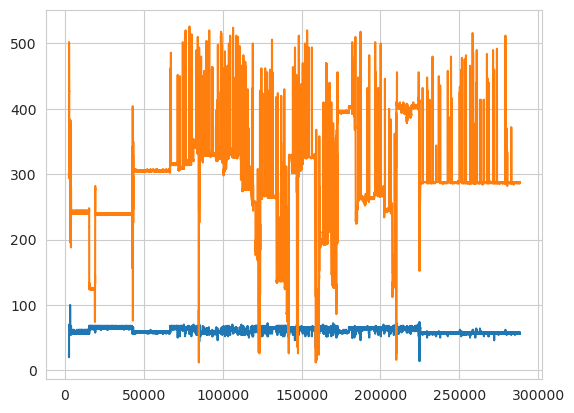

In [64]:
%matplotlib inline
plt.plot(ballpos)
#plt.plot(list(filter(lambda item: item is not None, ballpos[1]))


# Save Ball positions in a dataframe for analysis

In [68]:
trackresults = {
    'frame': list(range(1,len(ballpos)+1)),
    'xpos': list(map(lambda x: x[0], ballpos)),
    'ypos': list(map(lambda x: x[1], ballpos)),
}

df = pd.DataFrame(trackresults)

df.to_csv(VideoPath.parent.joinpath('BallPositions.csv').as_posix(), index=False)

In [1]:
# TODO : add adaptive equalization to the pipeline to account for edges videos that are not well lit.

# Supplementary 1: Understand how Hough circles parameters 1 and 2 work

Before performing the Hough transform, opencv's Hough circles function performs a canny edge detection. This algorithm uses the same parameters 1 and 2 and can be performed independently to see how frames would look like during processing.

![parameters 1 and 2 explanation](/home/durrieu/Tracking_Analysis/Tracktor/BallTracking/hysteresis.jpg)

In this image parameter 1 is maxVal, it is the threshold of gray values above which any pixel should be considered an edge. Conversely, parameter 2 is minVal. Any value below parameter 2 should be considered as not edge.

Once these values are set, edges are detected according to their connectivity. In this example, A is considered sure edge. B and C are both within the right threshold values but while C is connected to a sure edge, B isn't. B will not be considered as edge while C will.

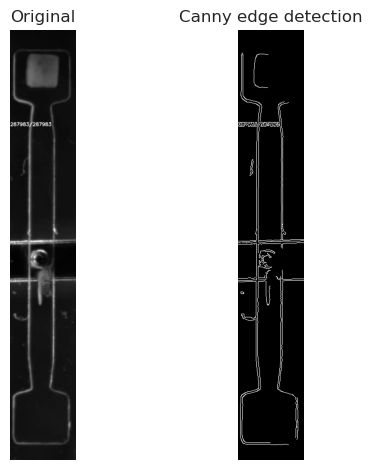

In [82]:
MinVal=100
MaxVal=200

cannyedge = cv2.Canny(im_full_gray, MinVal, MaxVal)

plt.subplot(1,2,1)
plt.imshow(im_full_gray, cmap='gray', vmin=0, vmax=255)
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cannyedge, cmap='gray', vmin=0, vmax=255)
plt.title('Canny edge detection')
plt.axis('off')

plt.tight_layout()
plt.show()

Note that in Canny syntax, parameter 1 and 2 are in the 'minval to maxval' order, while in the HoughCircles syntax it's the opposite.